In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import sys, os

from Bio import SeqIO
import Bio.PDB, warnings
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
from Bio import pairwise2

pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_new, data_processing
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [2]:
data_path = Path('/home', 'eclay','Pfam-A.full')
data_path = Path('Pfam-A.full')
data_path = Path('../Pfam-A.full')

DCA_ER_dir = Path('/home/evan/PycharmProjects/DCA_ER/')



pfam_id = 'PF14525'
pfam_id = 'PF03678'
pfam_id = 'PF03496'
pfam_id = 'PF00011'
pfam_id = 'PF00023'
pfam_id = 'PF00186'


n_jobs = 20
create_new = True
removing_cols = True
printing=True
remove_diagonals = False


DCA_ER_dir = '/data/cresswellclayec/DCA_ER/'
msa_npy_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
out_dir = '%sprotein_data/di/' % DCA_ER_dir
processed_data_dir = '%sprotein_data/data_processing_output' % DCA_ER_dir
pdb_dir = '%sprotein_data/pdb_data/' % DCA_ER_dir
# Define data directories
# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
print(pdb_df.head())
pdb_reference_ids = np.unique(pdb_df['pdb_id'].to_numpy())
print('PDB reference IDs:\n', pdb_reference_ids)

number of pdb structures: 372
        PF seq            id uniprot_start uniprot_end pdb_id chain pdb_start  \
0  PF00186  69  Q5KZ26_GEOKA             1         160   1ZDR     B         1   
1  PF00186  69  Q5KZ26_GEOKA             1         160   1ZDR     A         1   
2  PF00186  83  Q81R22_BACAN             2         160   3JWK     B         2   
3  PF00186  83  Q81R22_BACAN             2         160   3S9U     B         2   
4  PF00186  83  Q81R22_BACAN             2         160   3FL9     H         2   

  pdb_end  
0     160  
1     160  
2     160  
3     160  
4     160  
PDB reference IDs:
 ['1BOZ' '1CZ3' '1D1G' '1DDR' '1DDS' '1DF7' '1DG5' '1DG7' '1DG8' '1DHI'
 '1DHJ' '1DLR' '1DLS' '1DR1' '1DR2' '1DR3' '1DR4' '1DR5' '1DR6' '1DR7'
 '1DRA' '1DRB' '1DRE' '1DRF' '1DRH' '1DYH' '1DYI' '1DYJ' '1HFP' '1HFQ'
 '1HFR' '1JOL' '1JOM' '1JUV' '1KMS' '1KMV' '1MVS' '1MVT' '1OHJ' '1OHK'
 '1PD8' '1PD9' '1PDB' '1RA1' '1RA2' '1RA3' '1RA8' '1RA9' '1RB2' '1RB3'
 '1RC4' '1RD7' '1RE7' '1RF7' '1RG7' 

## Test Run of PDB-matching sequence from given MSA

In [3]:
# ipdb = 0
# printing = True
# print('seq:',int(pdb[ipdb,1]))

# start_time = timeit.default_timer()
# pdb_matches= tools.find_best_pdb(pfam_id, data_path, create_new=create_new)
# run_time = timeit.default_timer() - start_time

# print('finding best match takes %f seconds ' % run_time)



# index_pdb = 0
# pdb_select = pdb_matches.iloc[index_pdb]

# # enforce old PDB refs structure for PF00186
# pdb_select = pdb_matches.loc[pdb_matches['MSA Index']==69].iloc[0]

# query_seq = pdb_select['Query Aligned Seq']
# subject_seq = pdb_select['Subject Aligned Seq']
# mismatch_cols = [i for i,a in enumerate(query_seq) if a != subject_seq[i]]

# print(query_seq)
# print('Selected PDB: \n', pdb_select)

# print('\n\nMismatching Columns between query and subject: ', mismatch_cols)


## New Data Processing and Contact Mapping

In [5]:

# Set DCA_ER directory
DCA_dir = os.getcwd()

# Define data directories
# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
pdb_df.head()

number of pdb structures: 372


,PF,seq,id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end
0,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,B,1,160
1,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,A,1,160
2,PF00186,83,Q81R22_BACAN,2,160,3JWK,B,2,160
3,PF00186,83,Q81R22_BACAN,2,160,3S9U,B,2,160
4,PF00186,83,Q81R22_BACAN,2,160,3FL9,H,2,160


In [6]:
s0, removed_cols, s_index, tpdb, pdb_select \
= data_processing_new(data_path, pfam_id, index_pdb=0,gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, 
                        conserved_cols=0.9, printing=True, out_dir=processed_data_dir, pdb_dir=pdb_dir,  letter_format=False, 
                        remove_cols=removing_cols, create_new=create_new)


pdb_chain, ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range, poly_seq, pp_ca_coords_curated, pp_ca_coords_full_range \
= tools.contact_map_new(pdb_id=pdb_select['PDB ID'][:4], pdb_range=[pdb_select['Subject Beg'], pdb_select['Subject End']], \
                  removed_cols=removed_cols, queried_seq=pdb_select['Subject Aligned Seq'],  pdb_out_dir=pdb_dir)

Original Sequence length:  918
#

--------------------- Find Matching PDB Strucutre for MSA ----#
Raw-Query PDB dataframe gives 7714 matches... 

Sorted PDB matches (102 matches): 
       MSA Index  PDB ID  Score  Identity        E-value  Bitscore  \
6896       6896  3INV_1    1.0     1.000  7.508000e-138       432   
4761       4761  3CL9_1    1.0     1.000  1.411000e-137       431   
973         973  3INV_1    1.0     0.956  1.703000e-130       411   
5557       5557  1DR7_1    1.0     1.000  2.401000e-120       380   
250         250  3NXT_1    1.0     1.000  3.292000e-120       379   

      Alignment Length  Mismatches  Gaps Opened  Query Beg  Query End  \
6896               210           0            0          1        210   
4761               210           0            0          1        210   
973                208           9            0          1        208   
5557               182           0            0          1        182   
250                182           0    

[  6  13  14  21  26  30  34  41  42  43  45  48  53  54  56  60  96  97
 114 123 127]
[  6  13  14  21  26  30  34  41  42  43  45  48  53  54  56  60  96  97
 114 123 127]
(6573, 160)
(6573, 160)
[['M' 'I' 'S' ... 'W' 'E' 'R']
 ['-' 'L' 'A' ... 'Y' 'E' 'R']
 ['-' '-' '-' ... '-' '-' '-']
 ...
 ['-' 'V' 'S' ... 'Y' 'K' 'K']
 ['-' 'V' 'S' ... 'Y' 'E' 'R']
 ['-' 'F' 'S' ... 'Y' 'E' 'K']]
[['M' 'I' 'S' ... 'W' 'E' 'R']
 ['-' 'L' 'A' ... 'Y' 'E' 'R']
 ['-' '-' '-' ... '-' '-' '-']
 ...
 ['-' 'V' 'S' ... 'Y' 'K' 'K']
 ['-' 'V' 'S' ... 'Y' 'E' 'R']
 ['-' 'F' 'S' ... 'Y' 'E' 'K']]
A
MSA Index                                                             69
PDB ID                                                            1ZDR_1
Score                                                                1.0
Identity                                                           0.993
E-value                                                              0.0
Bitscore                                           

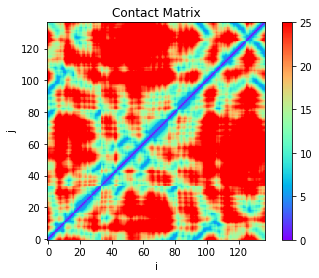

In [7]:

old_s0 = np.load('old_data_processing_s0.npy')
new_s0 = np.load('new_data_processing_s0.npy')
old_s1 = np.load('old_data_processing_s1.npy')
new_s1 = np.load('new_data_processing_s1.npy')
from data_processing import find_conserved_cols
old_cols = find_conserved_cols(old_s0, .8)
new_cols = find_conserved_cols(new_s0, .8)
print(old_cols)
print(new_cols)

print(old_s0.shape)
print(new_s0.shape)
print(old_s0)
print(new_s0)
print(pdb_chain)
print(pdb_select)
count = 0
for i, old_seq in enumerate(old_s0):
    for j, a in enumerate(old_seq):
        if a != new_s0[i,j]:
            print('found difference at %d, %d : %s %s' %(i,j, a, new_s0[i,j]))
            count +=1
print(count, ' differences before')

count = 0
for i, old_seq in enumerate(old_s1):
    for j, a in enumerate(old_seq):
        if a != new_s1[i,j]:
            print('found difference at %d, %d : %s %s' %(i,j, a, new_s1[i,j]))
            count +=1
print(count, ' differences after')
# tools.hide_toggle()

# print("Direct Information from Expectation reflection:\n",di)
def no_diag(mat, diag_l, s_index=None, make_big=False):
    rows, columns = mat.shape
    if make_big:
        new_mat = 100. * np.ones((rows,columns))
    else:
        new_mat = np.zeros((rows,columns))
    for row in range(rows):
        for col in range(columns):
            if s_index is None:
                if abs(row-col) > diag_l:
                    new_mat[row, col] = mat[row ,col]
            else:
                if abs(s_index[row]-s_index[col]) > diag_l:
                    new_mat[row, col] = mat[row ,col]    
    return new_mat


ct_nodiag = no_diag(ct, 4, s_index, make_big=True)
if remove_diagonals:
    ct_mat = ct_nodiag
else:
    ct_mat = ct

print('Contact matrix shape:', ct_mat.shape)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.title('Contact Matrix')
plt.imshow(ct_mat,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,25)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

In [8]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 137
Number of sequences: 6573
Number of different amino acids at each position [ 6 16 12  7  8 16  8 17 12 14  9 19 11 10 13  5  5 14  9  5 11  2  9 12
 10  9 10 16 17 11 12 13  5  4  9  7 11  6  5 10 12  9  9  9 17  8  8  2
  5  2 11 11 18 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21
 19 16 16 20 15 17 13 11  8 10 11 13  4  3 13 15 12 11 13 19  9 11 17  7
 14  8 16  3 16 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 19
 19 18 21 21 19 15 17 13 16 13 14 10 14  9 18 14  5]
Total number of variables 1697


In [9]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
# print("Amino Acid sequence Matrix\n",s0)
# print("OneHot sequence Matrix\n",s)
# print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

In [10]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

In [11]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [12]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

w_file = "%s/%s_w_new.npy" % (processed_data_dir, pfam_id)
if os.path.exists(w_file) and not create_new:
    w = np.load(w_file)
else:
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.



/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 198.09606172703207


In [13]:
# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)
np.save(w_file, w)

Dimensions of w:  (1697, 1697)


In [14]:
di = direct_info(s0,w)
print(di)
print(di.shape)
print(len(s_index))

[[0.         0.1199448  0.01898551 ... 0.00564456 0.00488064 0.00755727]
 [0.1199448  0.         0.02627245 ... 0.00509797 0.01021846 0.00936999]
 [0.01898551 0.02627245 0.         ... 0.00531219 0.00510337 0.00733113]
 ...
 [0.00564456 0.00509797 0.00531219 ... 0.         0.0373032  0.10681598]
 [0.00488064 0.01021846 0.00510337 ... 0.0373032  0.         0.09668451]
 [0.00755727 0.00936999 0.00733113 ... 0.10681598 0.09668451 0.        ]]
(137, 137)
137


## Run ER

ER DI shape:  (137, 137)
[  0   6  13  14 144 145  21  89  30 158 159  96  34  97  41  42  43  45
 114  53  56 123 127]
Final ER DI shape (cols removed):  (137, 137)


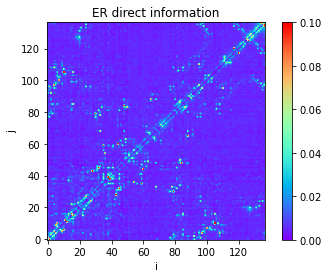

[  1   2   3   4   5   7   8   9  10  11  12  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  31  32  33  35  36  37  38  39  40  44  46
  47  48  49  50  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  90  91  92  93  94  95  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 115 116 117 118 119 120 121 122 124 125
 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 146
 147 148 149 150 151 152 153 154 155 156 157]
[[(12, 122), 0.3018530569407993], [(49, 50), 0.1881080346713492], [(35, 55), 0.1692962849234672], [(57, 73), 0.1630807864353907], [(136, 139), 0.14564036040565426], [(39, 58), 0.1435020011785381], [(61, 100), 0.14292558829778929], [(8, 12), 0.14234803323038786], [(15, 16), 0.1295520343162604], [(9, 117), 0.12427109693949195], [(1, 2), 0.11994480471776602], [(37, 93), 0.1194807306823681], [(146, 147), 0.11944554297600449], [(5, 113), 0.1160

In [15]:
#print("Direct Information from Expectation reflection:\n",di)
print('ER DI shape: ' , di.shape)
print(removed_cols)
if not removing_cols:
    er_di = np.delete(di, removed_cols,0)
    er_di = np.delete(er_di, removed_cols,1)
else:
    er_di = di

print('Final ER DI shape (cols removed): ', er_di.shape)

if remove_diagonals: 
    ER_di = no_diag(er_di, 4, s_index)
else:
    ER_di = er_di
    
plt.title('ER direct information')
plt.imshow(ER_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.1)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()


from ecc_tools import scores_matrix2dict
print(s_index)
ER_di_dict = scores_matrix2dict(ER_di, s_index, removed_cols, removing_cols=removing_cols)
print(ER_di_dict[:20])

ct thresh 4.000000 gives auc = 0.937006
ct thresh 4.117647 gives auc = 0.937006
ct thresh 4.235294 gives auc = 0.937187
ct thresh 4.352941 gives auc = 0.938650
ct thresh 4.470588 gives auc = 0.938650
ct thresh 4.588235 gives auc = 0.939897
ct thresh 4.705882 gives auc = 0.941403
ct thresh 4.823529 gives auc = 0.940594
ct thresh 4.941176 gives auc = 0.937784
ct thresh 5.058824 gives auc = 0.940873
ct thresh 5.176471 gives auc = 0.939349
ct thresh 5.294118 gives auc = 0.935556
ct thresh 5.411765 gives auc = 0.927076
ct thresh 5.529412 gives auc = 0.921445
ct thresh 5.647059 gives auc = 0.914685
ct thresh 5.764706 gives auc = 0.911274
ct thresh 5.882353 gives auc = 0.906637
ct thresh 6.000000 gives auc = 0.900349
ER auc max: 4.705882352941177 0.9414030598247507
ct thresh 4.705882 gives auc = 0.941403

Contact threshold:  4.705882352941177


Text(0, 0.5, 'Precision (PPV)')

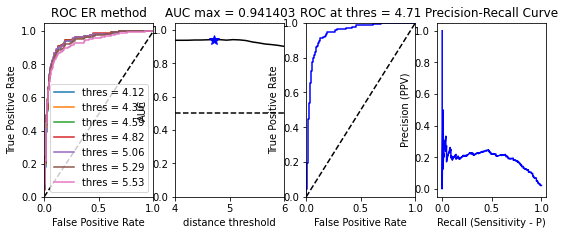

In [16]:
from ecc_tools import roc_curve, roc_curve_new, precision_curve
# find optimal threshold of distance
ct_thres = np.linspace(4.,6.,18,endpoint=True)
n = ct_thres.shape[0]


# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# # Find ct_threshold (2-6 Angstrom) which gives best contact prediction for ER
# auc_ER = np.zeros(n)
# for i in range(n):
#     try:
#         p,tp,fp = roc_curve(ct_mat, ER_di, ct_thres[i])
#         if i in iplot:
#             plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
#         auc_ER[i] = tp.sum()/tp.shape[0]
#     except(RuntimeWarning):
#         auc_ER[i] = 0
# Find ct_threshold (2-6 Angstrom) which gives best contact prediction for ER
# p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct_mat, ER_di, ct_thres[i0_ER])

auc_ER = np.zeros(n)
for i in range(n):
    try:
        fpr, tpr, thresholds, auc = roc_curve_new(ct_mat, ER_di, ct_thres[i])
        if i in iplot:
            plt.plot(fpr, tpr, label='thres = %3.2f'%ct_thres[i])
        auc_ER[i] = auc
    except:
        auc_ER[i] = 0
  
# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
fpr0_ER, tpr0_ER, thresholds_ER, auc = roc_curve_new(ct_mat, ER_di, ct_thres[i0_ER])

# ROC-curve tile settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])      
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC ER method")
plt.legend(loc="lower right") 


# Plot ROC, AUC and Precision for best ER contact prediction
# AUC
plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'k-')
plt.plot(ct_thres[i0_ER],auc_ER[i0_ER], 'b*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_ER.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
# ROC
plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_ER]))
plt.plot(fpr0_ER,tpr0_ER,'b-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Precision-Recall
plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
precision_ER, recall_ER, threshold = precision_curve(ct_mat, ER_di, ct_thres[i0_ER])
print('\nContact threshold: ', ct_thres[i0_ER])
plt.plot( recall_ER, precision_ER, 'b-', label='thres = %s'%ct_thres[i0_ER])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

## Run our MF

In [17]:
from inference_dca import direct_info_dca
print(s0.shape)
seq_wt_file = None
seq_wt_file = '%s/protein_data/data_processing_output/seq_weight_%s.npy' % (DCA_ER_dir, pfam_id)
our_mf_file = '%s/protein_data/di/%s_MF_di.npy' % (DCA_ER_dir, pfam_id)
# ----------- DCA DI (MF) calculation --------------------------------------------- #
if os.path.exists(our_mf_file) and not create_new:
    mf_di = np.load(our_mf_file)
else:
    mf_di, fi, fij, c, cinv, w, w2d, fi_pydca, fij_pydca, c_pydca, c_inv_pydca, \
    w_pydca, w2d_pydcak, di_pydca, ma_inv,seq_ints\
    = direct_info_dca(s0, seq_wt_outfile=seq_wt_file)
    print('c[0]:',c[0])
    print('c_pydca[0]', c_pydca[0])
    np.save(our_mf_file, mf_di)

(6573, 137)
(6573, 137)
ma_inv (sequences weight shape:  (6573,)
tais meff = 4765.320193
meff for our MF =  4765.320192924858
(137, 21)
(137, 21)
(9316, 20, 20)
2740
c[0]: [ 0.02324263 -0.00056689 -0.00056689 ...  0.00056689 -0.00019815
 -0.00546963]
c_pydca[0] [ 0.02324263 -0.00056689 -0.00056689 ... -0.0001985  -0.00547266
 -0.00176592]


[[(12, 122), 0.41608429767514504], [(146, 147), 0.36108581540637713], [(149, 150), 0.3241283466003026], [(148, 149), 0.319368975404829], [(155, 157), 0.30280768491676974], [(57, 73), 0.2969173849818398], [(136, 139), 0.2944656894142206], [(5, 7), 0.2824818241001353], [(156, 157), 0.26579019208633103], [(151, 152), 0.25402159003094715], [(155, 156), 0.24937366366602953], [(8, 12), 0.2343167557758848], [(142, 143), 0.22547846017126782], [(153, 154), 0.2235370582786164], [(49, 50), 0.22318590141428668], [(152, 153), 0.2206884800295168], [(148, 150), 0.21986331569259768], [(153, 155), 0.20731308855359046], [(35, 55), 0.2070070444487777], [(154, 155), 0.20273711742599548]]
(137, 137)


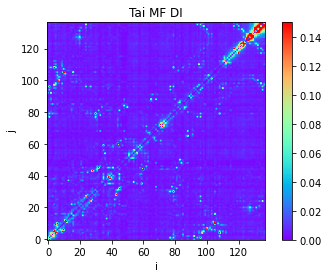

In [18]:
if not removing_cols:
    MF_di_temp = np.delete(mf_di, removed_cols,0)
    MF_di_temp = np.delete(MF_di_temp, removed_cols,1)

else:
    MF_di_temp = mf_di

if remove_diagonals:
    MF_di = no_diag(MF_di_temp, 4, s_index)
else:
    MF_di = MF_di_temp

# --------------------------------------------------------------------------------- #
MF_di_dict = scores_matrix2dict(MF_di, s_index,  removed_cols, removing_cols=removing_cols)
print(MF_di_dict[:20])

print(MF_di.shape)
plt.title('Tai MF DI')
plt.imshow(MF_di, cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.15)

plt.colorbar(fraction=0.045, pad=0.05)


ct thresh 4.000000 gives auc = 0.904852
ct thresh 4.117647 gives auc = 0.904852
ct thresh 4.235294 gives auc = 0.903413
ct thresh 4.352941 gives auc = 0.905585
ct thresh 4.470588 gives auc = 0.905585
ct thresh 4.588235 gives auc = 0.906722
ct thresh 4.705882 gives auc = 0.909371
ct thresh 4.823529 gives auc = 0.903211
ct thresh 4.941176 gives auc = 0.900858
ct thresh 5.058824 gives auc = 0.905268
ct thresh 5.176471 gives auc = 0.906315
ct thresh 5.294118 gives auc = 0.901351
ct thresh 5.411765 gives auc = 0.897956
ct thresh 5.529412 gives auc = 0.894977
ct thresh 5.647059 gives auc = 0.886864
ct thresh 5.764706 gives auc = 0.884514
ct thresh 5.882353 gives auc = 0.881666
ct thresh 6.000000 gives auc = 0.872631
auc max: 4.705882352941177 0.9093710413248903
ct thresh 4.705882 gives auc = 0.909371


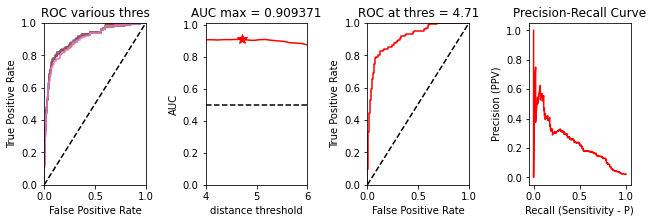

In [19]:
# Run our version of MF di scores through Average Product Correction (to combat influences of phylogeny)
# mf_APC = score_APC(MF_di, sequence_length, s_index)
# MF_di = tools.di_dict2mat(mf_APC, cols_removed, s_index)

# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# find optimal threshold of distance
auc_MF = np.zeros(n)

for i in range(n):
    try:
#         p,tp,fp = roc_curve(ct_mat, MF_di, ct_thres[i])
        fpr, tpr, thresholds, auc = roc_curve_new(ct_mat, MF_di, ct_thres[i])
        
        if i in iplot:
#             plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
            plt.plot(fpr, tpr, label='thres = %3.2f'%ct_thres[i])

#         auc_MF[i] = tp.sum()/tp.shape[0]
        auc_MF[i] = auc
    except:
        auc_MF[i] = 0
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
        
i0_MF = np.argmax(auc_MF)
print('auc max:',ct_thres[i0_MF],auc_MF[i0_MF])
# p0_MF,tp0_MF,fp0_MF = tools.roc_curve(ct_mat, MF_di,ct_thres[i0_MF])
fpr0_MF, tpr0_MF, thresholds, auc = roc_curve_new(ct_mat, MF_di, ct_thres[i0_MF])


plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_MF[i0_MF]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_MF,'r-')
plt.plot(ct_thres[i0_MF],auc_MF[i0_MF], 'r*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_MF.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_MF]))
# plt.plot(fp0_MF,tp0_MF,'r-')
plt.plot(fpr0_MF,tpr0_MF,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
precision_MF, recall_MF, threshold = precision_curve(ct_mat, MF_di, ct_thres[i0_MF])
# plt.plot(p0_MF, tp0_MF / (tp0_MF + fp0_MF), 'r-', label='thres = %s'%ct_thres[i0_MF])
plt.plot(recall_MF, precision_MF, 'r-', label='thres = %s'%ct_thres[i0_MF])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)

/data/cresswellclayec/DCA_ER/protein_data/di/PF00186_DI_pydca_mf.npy
[[(12, 122) 0.43398923485295177]
 [(136, 139) 0.2904765508466798]
 [(57, 73) 0.2898701897364931]
 ...
 [(130, 146) -0.0013977324164215082]
 [(1, 130) -0.0015675357006088558]
 [(0, 152) -0.002465694483227414]]
[[(12, 122) 0.10672505875146289]
 [(35, 55) 0.07809734916873629]
 [(57, 73) 0.07243114624499762]
 ...
 [(96, 130) 2.1068048662662887e-05]
 [(31, 42) 2.0593257835086886e-05]
 [(97, 130) 1.8176722729202402e-05]]
[  0   6  13  14 144 145  21  89  30 158 159  96  34  97  41  42  43  45
 114  53  56 123 127]
DI shape (full size) (160, 160)
DI shape (scores removed) (137, 137) 
(should be same as ER di shape..)
DI shape (full size) (160, 160)
DI shape (scores removed) (137, 137) 
(should be same as ER di shape..)
[[(12, 122), 0.43398923485295177], [(136, 139), 0.2904765508466798], [(57, 73), 0.2898701897364931], [(5, 7), 0.254719197302837], [(49, 50), 0.2522852136969278], [(8, 12), 0.22700670036595672], [(35, 55), 0.20

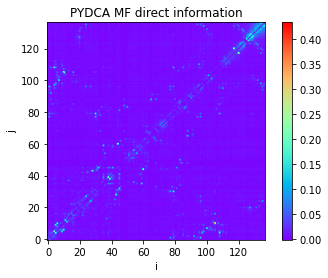

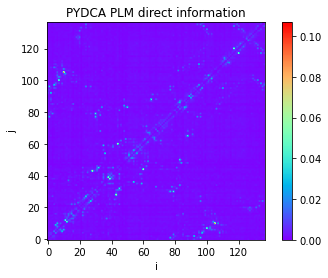

In [29]:
method = 'DI'
# Load pydca score pseudo-dictionaries and generate di matrices from them..
plm_score_file = '%s%s_%s_pydca_plm.npy' % (out_dir, pfam_id, method)
mf_score_file = '%s%s_%s_pydca_mf.npy' % (out_dir, pfam_id, method)

# plm_score_file = '%s%s_%s_pydca_plm_di.npy' % (out_dir, pfam_id, method)  

# list of di scores length of: seq_len choose 2 
# (ie for PF00186 with sequence length 160, this should be length 160 choose 2 = 12720)
mf_scores = np.load(mf_score_file, allow_pickle=True)
plm_scores = np.load(plm_score_file, allow_pickle=True)
print(mf_score_file)
print(mf_scores)
print(plm_scores)
                                                                           
def di_dict2mat_new(pydca_score, s_index, curated_cols = None, full_contact=False, aa_index_correction=True, removing_cols=False):
    # This functions converts the dictionary (with 2 int index tuple as keys) of pydca scores to a di matrix which
    #   incorporates the removed columns during pre-processing (cols_removed) resulting in a pydca di matrix with
    #   correct dimensions
    #for pair, score in pydca_score:                                                                     
    #    print(pair, score)

    if removing_cols:
        column_count = len(s_index) + len(curated_cols) # s_index is too short to capture all PYDCA contacts                                         
    else:
        column_count = len(s_index) # s_index should be full column set (curated columns would make it tooo long)

    pydca_di = np.zeros((column_count, column_count))
    for [(i, j), score] in pydca_score:                                                                  
#         if aa_index_correction:                                                                          
#             if i in s_index and j in s_index:
#                 ii = np.where(s_index==i)[0][0]                                                        
#                 jj = np.where(s_index==j)[0][0]  
#                 pydca_di[ii, jj] = score                                                                 
#                 pydca_di[jj, ii] = score 
#             elif i not in curated_cols and j not in curated_cols:
#                 print('ERROR: MISMATCH IN INDICES (%d, %d) PYDCA and us' % (i, j))
#                 sys.exit()

#         else:
        pydca_di[i, j] = score 
        pydca_di[j, i] = score 
                                                                                                         
    print('DI shape (full size)' , pydca_di.shape)
    if curated_cols is not None and removing_cols:   # have we curated (set to gap instead of removed) 
                                                        # but not removed columns?
        # trim the columns removed during the pre-processing for ER                                      
        pydca_di = np.delete(pydca_di, curated_cols, 0)                                                  
        pydca_di = np.delete(pydca_di, curated_cols, 1)                                                  
    print('DI shape (scores removed)', pydca_di.shape,'\n(should be same as ER di shape..)')             
        
    return pydca_di

print(removed_cols)
# NOTE: PYDCA always keeps columns ie removing columnds is False
pydca_MF_di = di_dict2mat_new(mf_scores, s_index, curated_cols=removed_cols, aa_index_correction=True, removing_cols = removing_cols)
pydca_PLM_di = di_dict2mat_new(plm_scores, s_index, curated_cols=removed_cols, aa_index_correction=True, removing_cols = removing_cols)

if remove_diagonals:
    PYDCA_MF_di = no_diag(pydca_MF_di, 4, s_index)
    PYDCA_PLM_di = no_diag(pydca_PLM_di, 4, s_index)
else:
    PYDCA_MF_di = pydca_MF_di
    PYDCA_PLM_di = pydca_PLM_di
    
pydcaMF_di_dict = scores_matrix2dict(PYDCA_MF_di, s_index, removed_cols, removing_cols=removing_cols)
print(pydcaMF_di_dict[:20])

pydcaPLM_di_dict = scores_matrix2dict(PYDCA_PLM_di, s_index, removed_cols, removing_cols=removing_cols)
print(pydcaPLM_di_dict[:20])
    
plt.title('PYDCA MF direct information')
plt.imshow(PYDCA_MF_di, cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

plt.title('PYDCA PLM direct information')
plt.imshow(PYDCA_PLM_di, cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()


ct thresh 4.000000 gives auc = 0.919520
ct thresh 4.117647 gives auc = 0.919520
ct thresh 4.235294 gives auc = 0.917885
ct thresh 4.352941 gives auc = 0.919745
ct thresh 4.470588 gives auc = 0.919745
ct thresh 4.588235 gives auc = 0.920600
ct thresh 4.705882 gives auc = 0.922758
ct thresh 4.823529 gives auc = 0.916991
ct thresh 4.941176 gives auc = 0.914640
ct thresh 5.058824 gives auc = 0.918267
ct thresh 5.176471 gives auc = 0.918527
ct thresh 5.294118 gives auc = 0.914046
ct thresh 5.411765 gives auc = 0.910531
ct thresh 5.529412 gives auc = 0.906148
ct thresh 5.647059 gives auc = 0.898699
ct thresh 5.764706 gives auc = 0.892548
ct thresh 5.882353 gives auc = 0.890247
ct thresh 6.000000 gives auc = 0.881281
auc max: 4.705882352941177 0.9227584704216145
ct thresh 4.705882 gives auc = 0.922758


PLM


ct thresh 4.000000 gives auc = 0.905046
ct thresh 4.117647 gives auc = 0.905046
ct thresh 4.235294 gives auc = 0.904960
ct thresh 4.352941 gives auc = 0.907247
ct thresh 4.470588 gives a

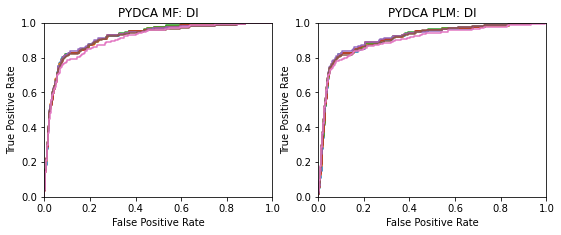

In [30]:
# which contact matrix do you want to use (full or curated)
ct_mat = ct_full # full pdb contact matrix without columns removed
ct_mat = ct  # full pdb contact matrix with conserved and bad columns removed (defined during pre-processing)
plt.figure(figsize=(9.0,3.2))

plt.title('ROC for PYDCA scores')

# PYDCA-MF
auc_pydca_MF = np.zeros(n)

ax1 = plt.subplot2grid((1,2),(0,0))
for i in range(n):
    try:
#         p,tp,fp = roc_curve(ct_mat, PYDCA_MF_di, ct_thres[i])
        fpr, tpr, thresholds, auc = roc_curve_new(ct_mat, PYDCA_MF_di, ct_thres[i])

        if i in iplot:
#             ax1.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
            ax1.plot(fpr,tpr,label='thres = %3.2f'%ct_thres[i])
#         auc_pydca_MF[i] = tp.sum()/tp.shape[0]
        auc_pydca_MF[i] = auc
    except:
        auc_pydca_MF[i] = 0
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('PYDCA MF: %s' % method)
        
i0_pydca_MF = np.argmax(auc_pydca_MF)
print('auc max:',ct_thres[i0_pydca_MF],auc_pydca_MF[i0_pydca_MF])
# p0_pydca_MF,tp0_pydca_MF,fp0_pydca_MF = tools.roc_curve(ct_mat, PYDCA_MF_di,ct_thres[i0_pydca_MF])
fpr0_pydca_MF, tpr0_pydca_MF, thresholds, auc = roc_curve_new(ct_mat, PYDCA_MF_di, ct_thres[i0_pydca_MF])

print('\n\nPLM\n\n')
# PYDCA-PLM
auc_pydca_PLM = np.zeros(n)

ax2 = plt.subplot2grid((1,2),(0,1))
for i in range(n):
    try:
#         p,tp,fp = roc_curve(ct_mat, PYDCA_PLM_di, ct_thres[i])
        fpr, tpr, thresholds, auc = roc_curve_new(ct_mat, PYDCA_PLM_di, ct_thres[i])
        if i in iplot:
#             ax2.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
            ax2.plot(fpr,tpr,label='thres = %3.2f'%ct_thres[i])
#         auc_pydca_PLM[i] = tp.sum()/tp.shape[0]
        auc_pydca_PLM[i] = auc
    except:
        auc_pydca_PLM[i] = 0
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('PYDCA PLM: %s' % method)
        
i0_pydca_PLM = np.argmax(auc_pydca_PLM)
print('auc max:',ct_thres[i0_pydca_PLM],auc_pydca_PLM[i0_pydca_PLM])
# p0_pydca_PLM,tp0_pydca_PLM,fp0_pydca_PLM = tools.roc_curve(ct_mat, PYDCA_PLM_di, ct_thres[i0_pydca_PLM])
fpr0_pydca_PLM, tpr0_pydca_PLM, thresholds, auc = roc_curve_new(ct_mat, PYDCA_PLM_di, ct_thres[i0_pydca_PLM])


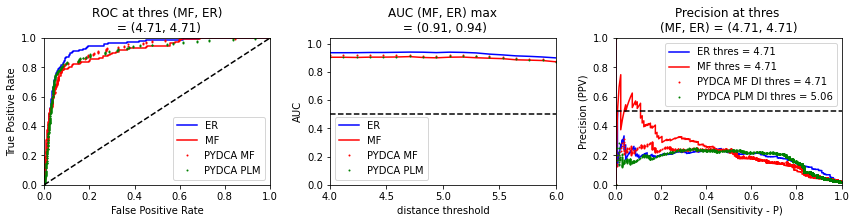

In [31]:
plt.figure(figsize=(12.0,3.2))

# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (MF, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot(fpr0_ER,tpr0_ER,'b-',label="ER")
plt.plot(fpr0_MF,tpr0_MF,'r-',label="MF")
plt.plot(fpr0_pydca_MF,tpr0_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(fpr0_pydca_PLM,tpr0_pydca_PLM,'go',label="PYDCA PLM", markersize=1)

plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (MF, ER) max\n = (%3.2f, %3.2f)' %(auc_MF[i0_MF], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'b-',label="ER")
plt.plot(ct_thres,auc_MF,'r-',label="MF")
plt.plot(ct_thres,auc_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(ct_thres,auc_pydca_PLM,'go',label="PYDCA PLM", markersize=1)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,max(auc_MF.max(), auc_ER.max())+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(MF, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
precision_pydca_MF, recall_pydca_MF, threshold = precision_curve(ct_mat, PYDCA_MF_di, ct_thres[i0_pydca_MF])
precision_pydca_PLM, recall_pydca_PLM, threshold = precision_curve(ct_mat, PYDCA_PLM_di, ct_thres[i0_pydca_PLM])

plt.plot( recall_ER, precision_ER,'b-',label='ER thres = %3.2f'%ct_thres[i0_ER])
plt.plot( recall_MF, precision_MF,'r-',label='MF thres = %3.2f'%ct_thres[i0_MF])
plt.plot( recall_pydca_MF, precision_pydca_MF,'ro',label='PYDCA MF %s thres = %3.2f' % (method, ct_thres[i0_pydca_MF]), markersize=1)
plt.plot( recall_pydca_PLM, precision_pydca_PLM,'go',label='PYDCA PLM %s thres = %3.2f' % (method, ct_thres[i0_pydca_PLM]), markersize=1)

plt.plot([0,1.],[.5,.5],'k--')
plt.xlim([0,1])
plt.ylim([0,1]) 
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)

plt.savefig('ERvPYDCA_%s_comparison.pdf' % method)


# tools.hide_toggle()